In [1]:
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch as T
from torch.distributions.categorical import Categorical

In [3]:
class PPOMemory:
    def __init__(self, batch_size):
        self.states = []
        self.probs = []
        self.vals = []
        self.actions = []
        self.rewards = []

        self.batch_size = batch_size

    def generate_batches(self):
        n_states = len(self.states)
        batch_start = np.arange(0, n_states, self.batch_size)
        indices = np.arange(n_states, dtype=np.int64)
        np.random.shuffle(indices)
        batches = [indices[i:i+self.batch_size] for i in batch_start]

        return np.array(self.states),\
                np.array(self.actions),\
                np.array(self.probs),\
                np.array(self.vals),\
                np.array(self.rewards),\
                batches

    def store_memory(self, state, action, probs, vals, reward):
        self.states.append(state)
        self.actions.append(action)
        self.probs.append(probs)
        self.vals.append(vals)
        self.rewards.append(reward)

    def clear_memory(self):
        self.states = []
        self.probs = []
        self.actions = []
        self.rewards = []
        self.vals = []

In [4]:
class ActorNetwork(nn.Module):
    def __init__(self, n_actions, input_dims, alpha,
            fc1_dims=256, fc2_dims=256, chkpt_dir='tmp/ppo'):
        super(ActorNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'actor_torch_ppo')
        self.actor = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, n_actions),
                nn.Softmax(dim=-1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        dist = self.actor(state)
        dist = Categorical(dist)
        
        return dist

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

class CriticNetwork(nn.Module):
    def __init__(self, input_dims, alpha, fc1_dims=256, fc2_dims=256,
            chkpt_dir='tmp/ppo'):
        super(CriticNetwork, self).__init__()

        self.checkpoint_file = os.path.join(chkpt_dir, 'critic_torch_ppo')
        self.critic = nn.Sequential(
                nn.Linear(*input_dims, fc1_dims),
                nn.ReLU(),
                nn.Linear(fc1_dims, fc2_dims),
                nn.ReLU(),
                nn.Linear(fc2_dims, 1)
        )

        self.optimizer = optim.Adam(self.parameters(), lr=alpha)
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        value = self.critic(state)

        return value

    def save_checkpoint(self):
        T.save(self.state_dict(), self.checkpoint_file)

    def load_checkpoint(self):
        self.load_state_dict(T.load(self.checkpoint_file))

In [6]:
class Agent:
    def __init__(self, n_actions, input_dims, gamma=0.99, alpha=0.0003, gae_lambda=0.95,
            policy_clip=0.2, batch_size=64, n_epochs=10):
        self.gamma = gamma
        self.policy_clip = policy_clip
        self.n_epochs = n_epochs
        self.gae_lambda = gae_lambda

        self.actor = ActorNetwork(n_actions, input_dims, alpha)
        self.critic = CriticNetwork(input_dims, alpha)
        self.memory = PPOMemory(batch_size)
       
    def remember(self, state, action, probs, vals, reward):
        self.memory.store_memory(state, action, probs, vals, reward)

    def save_models(self):
        print('... saving models ...')
        self.actor.save_checkpoint()
        self.critic.save_checkpoint()

    def load_models(self):
        print('... loading models ...')
        self.actor.load_checkpoint()
        self.critic.load_checkpoint()

    def choose_action(self, observation):
        state = T.tensor([observation], dtype=T.float).to(self.actor.device)

        dist = self.actor(state)
        value = self.critic(state)
        action = dist.sample()

        probs = T.squeeze(dist.log_prob(action)).item()
        action = T.squeeze(action).item()
        value = T.squeeze(value).item()
        T_chws_set.value = action+6

        return action, probs, value

    def learn(self):
        for _ in range(self.n_epochs):
            state_arr, action_arr, old_prob_arr, vals_arr,\
            reward_arr, batches = \
                    self.memory.generate_batches()

            values = vals_arr
            advantage = np.zeros(len(reward_arr), dtype=np.float32)

            for t in range(len(reward_arr)-1):
                discount = 1
                a_t = 0
                for k in range(t, len(reward_arr)-1):
                    a_t += discount*(reward_arr[k] + self.gamma*values[k+1]*\
                            (1-int(dones_arr[k])) - values[k])
                    discount *= self.gamma*self.gae_lambda
                advantage[t] = a_t
            advantage = T.tensor(advantage).to(self.actor.device)

            values = T.tensor(values).to(self.actor.device)
            for batch in batches:
                states = T.tensor(state_arr[batch], dtype=T.float).to(self.actor.device)
                old_probs = T.tensor(old_prob_arr[batch]).to(self.actor.device)
                actions = T.tensor(action_arr[batch]).to(self.actor.device)

                dist = self.actor(states)
                critic_value = self.critic(states)

                critic_value = T.squeeze(critic_value)

                new_probs = dist.log_prob(actions)
                prob_ratio = new_probs.exp() / old_probs.exp()
                #prob_ratio = (new_probs - old_probs).exp()
                weighted_probs = advantage[batch] * prob_ratio
                weighted_clipped_probs = T.clamp(prob_ratio, 1-self.policy_clip,
                        1+self.policy_clip)*advantage[batch]
                actor_loss = -T.min(weighted_probs, weighted_clipped_probs).mean()

                returns = advantage[batch] + values[batch]
                critic_loss = (returns-critic_value)**2
                critic_loss = critic_loss.mean()

                total_loss = actor_loss + 0.5*critic_loss
                self.actor.optimizer.zero_grad()
                self.critic.optimizer.zero_grad()
                total_loss.backward()
                self.actor.optimizer.step()
                self.critic.optimizer.step()

        self.memory.clear_memory()   

Initialization of Arrays

In [7]:
score_history = []
eps_history = []
power_history = []
setpoints_history = []



for i in range(5):
    empty_array1 = []
    power_history.append(empty_array1)
    empty_array2 = []
    setpoints_history.append(empty_array2)

keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

5 Episodes

In [10]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state
import numpy as np


agent = Agent( n_actions=10 , batch_size = 5, n_epochs = 5, input_dims=(10,))

for episode in range(5):  
    env = energyplus.ooep.ems.Environment().__enter__()

    sm_env = ooep.addons.state.StateMachine(env)
    sm_stepf = sm_env.step_function(
        dict(event_name='begin_zone_timestep_after_init_heat_balance')
    )

    sm_env.run(
        '--output-directory', 'build3/demo-eplus',
        '--weather', f'./SGP_Singapore_486980_IWEC.epw',
        f'./jan4.idf',
        verbose=True,
    )

    while True:

        sm_stepf()


        try:

            P_ch = [env.variable(dict(
                        variable_name='Chiller Electricity Rate',
                        variable_key=key)) for key in keys]
            power = P_ch[0].value + P_ch[1].value + P_ch[2].value

            print(power)
            break

        except ooep.ems.NotReadyError: pass


    score = 0

    for step in range(1, 7650):
        P_ch = [env.variable(dict(
            variable_name='Chiller Electricity Rate',
            variable_key=key)) for key in keys]
        E_ch = [env.variable(dict(
            variable_name='Chiller Electricity', 
            variable_key=key)) for key in keys]
        T_outdoor = env.variable(dict(
            variable_name='Site Outdoor Air Drybulb Temperature',
            variable_key='ENVIRONMENT'))
        T_chws = [env.variable(dict(
            variable_name='Chiller Evaporator Outlet Temperature', 
            variable_key=key)) for key in keys]
        T_chwr = [env.variable(dict(
            variable_name='Chiller Evaporator Inlet Temperature', 
            variable_key=key)) for key in keys]
        T_chws_set = env.actuator(dict(
            component_type='System Node Setpoint',
            control_type = 'Temperature Setpoint', 
            actuator_key='CHW Loop Supply Side Outlet'))
        
        obs = []
        power_sum = 0

        # Add Chiller Electricity values to the observation space
        for chiller_electricity_rate in P_ch:
            obs.append(chiller_electricity_rate.value)
            power_sum += chiller_electricity_rate.value
        
        obs.append(T_outdoor.value)

        for chiller_evaporator_outlet_temp in T_chws:
            obs.append(chiller_evaporator_outlet_temp.value)

        for chiller_evaporator_inlet_temp in T_chwr:
            obs.append(chiller_evaporator_inlet_temp.value)
        
        #if power_sum != 0:
            #reward = 120000/ (power_sum)
        #else:
            #reward = 0

        K1 = 0.6
        K2 = 0.4
        S1 = 0.5
        S2 = 0.14
        T_chwr_ref = 17
        P_ref = 120000

        reward = K1*(1 - (power_sum/P_ref)) + K2*(1/(1 + S1*np.exp(S2*(T_chwr[0].value - T_chwr_ref)) ))

        score += reward

        action, prob, val  = agent.choose_action(obs)
        sm_stepf()

        '''P_ch_ = [env.variable(dict(
            variable_name='Chiller Electricity Rate',
            variable_key=key)) for key in keys]
        E_ch_ = [env.variable(dict(
            variable_name='Chiller Electricity', 
            variable_key=key)) for key in keys]
        T_outdoor_ = env.variable(dict(
            variable_name='Site Outdoor Air Drybulb Temperature',
            variable_key='ENVIRONMENT'))
        T_chws_ = [env.variable(dict(
            variable_name='Chiller Evaporator Outlet Temperature', 
            variable_key=key)) for key in keys]
        T_chwr_ = [env.variable(dict(
            variable_name='Chiller Evaporator Inlet Temperature', 
            variable_key=key)) for key in keys]
        T_chws_set_ = env.actuator(dict(
            component_type='System Node Setpoint',
            control_type = 'Temperature Setpoint', 
            actuator_key='CHW Loop Supply Side Outlet'))
                
        obs_ = []
        for chiller_electricity_rate in P_ch_:
            obs_.append(chiller_electricity_rate.value)

        obs_.append(T_outdoor_.value)

        for chiller_evaporator_outlet_temp in T_chws_:
            obs_.append(chiller_evaporator_outlet_temp.value)

        for chiller_evaporator_inlet_temp in T_chwr_:
            obs_.append(chiller_evaporator_inlet_temp.value)'''


        agent.remember(obs, action, prob, val, reward)
        agent.learn()

        print(rf"Episode={episode+1} Step={step}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chwr1={T_chwr[0].value}) (T_chwr2={T_chwr[1].value}) (T_chwr3={T_chwr[2].value})(T_chws1={T_chws[0].value}) (T_chws2={T_chws[1].value}) (T_chws3={T_chws[2].value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

        setpoints_history[episode].append(action + 6)
        power_history[episode].append(power_sum)

    score_history.append(score)

Episode=1 Step=1  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.96666666666667) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=10) 
Episode=1 Step=2  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.96666666666667) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=8) 
Episode=1 Step=3  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.9) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=10) 
Episode=1 Step=4  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.9) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=8) 
Episode=1 Step=5  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.833333333333336) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=12) 
Episode=1 Step=6  P_ch=(0.0, 0.0, 0.0)) Reward=

0.0


Episode=1 Step=8  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.766666666666666) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=14) 
Episode=1 Step=9  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.7) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=7) 
Episode=1 Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.7) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=10) 
Episode=1 Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.65) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=8) 
Episode=1 Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T_outdoor=24.65) (T_chwr1=0.0) (T_chwr2=0.0) (T_chwr3=0.0)(T_chws1=0.0) (T_chws2=0.0) (T_chws3=0.0) (T_chws_set=8) 
Episode=1 Step=13  P_ch=(0.0, 0.0, 0.0)) Reward=0.9823085609485325 (T

KeyboardInterrupt: 

In [13]:
T_chwsnew = env.variable(dict(variable_name='Chiller Evaporator Outlet Temperature', variable_key='Chiller'))
print(T_chwsnew.value)


0.0


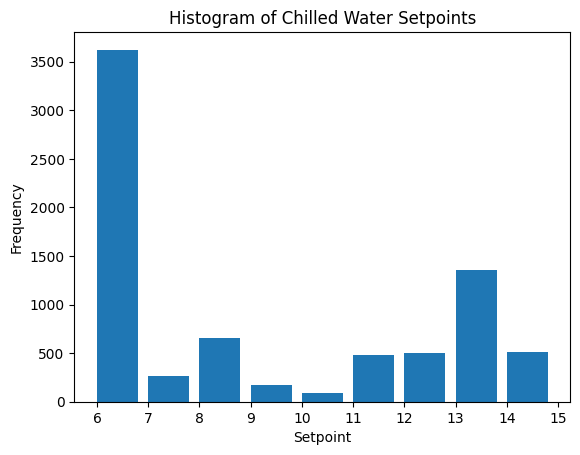

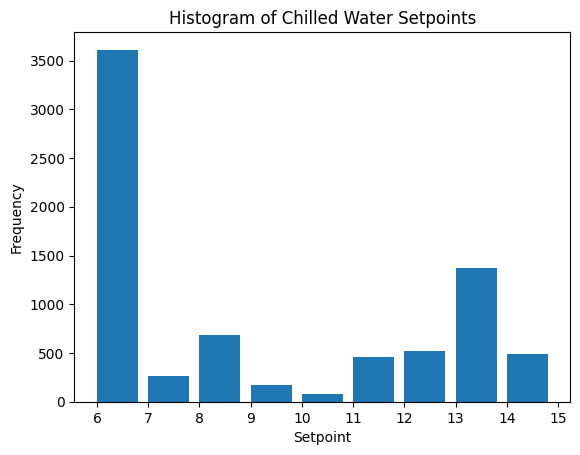

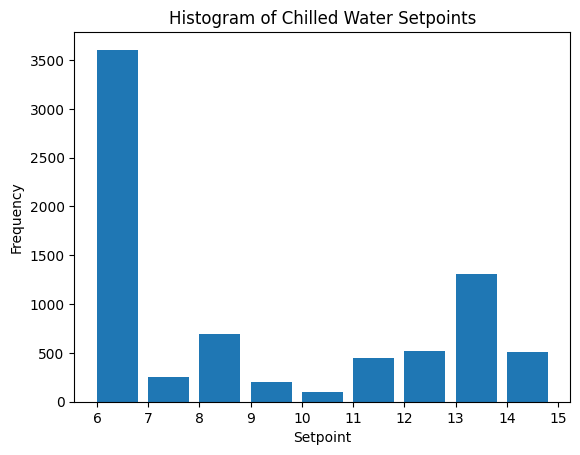

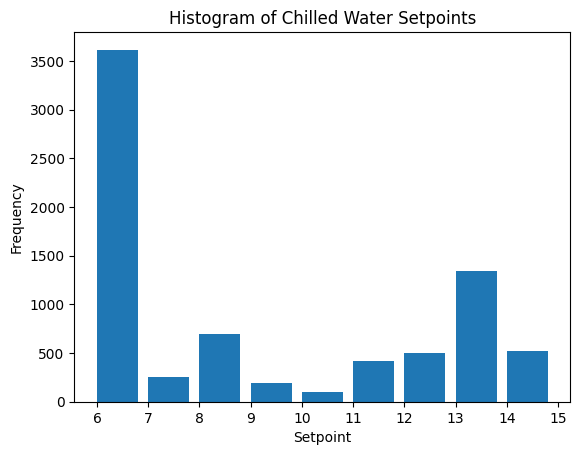

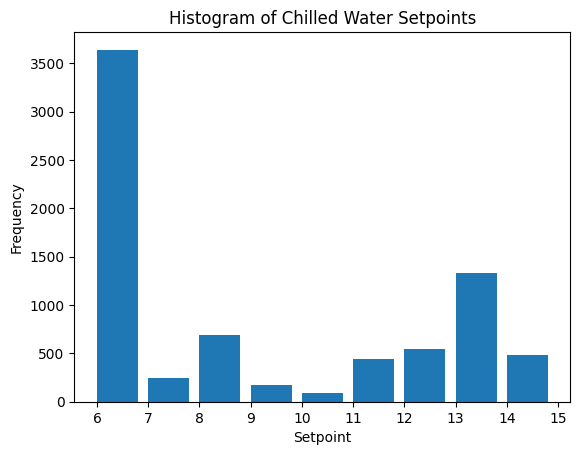

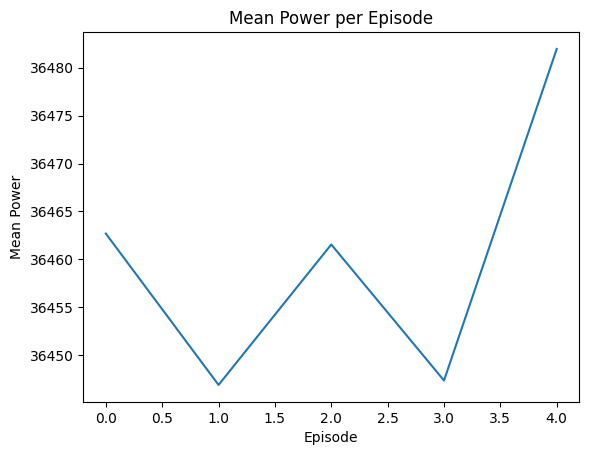

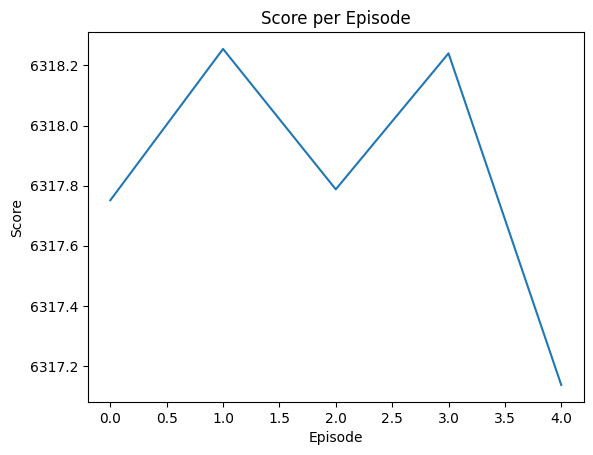

In [13]:
import numpy as np
import matplotlib.pyplot as plt

mean_power_history = []

for episode in range(5):
    mean_power_history.append(np.mean(power_history[episode]))

    '''
    plt.plot(power_history[episode])
    plt.xlabel('Step')
    plt.ylabel('Total Power')
    plt.title('Total Power per Step' + f' (Episode {episode+1})')
    plt.show()
    '''

    counts, bins = np.histogram(setpoints_history[episode], bins=np.arange(6, 16))

    plt.bar(bins[:-1], counts, width=0.8, align='edge')
    plt.xlabel('Setpoint')
    plt.ylabel('Frequency')
    plt.title('Histogram of Chilled Water Setpoints')
    plt.xticks(np.arange(6, 16))
    plt.show()
    

plt.plot(mean_power_history)
plt.xlabel('Episode')
plt.ylabel('Mean Power')
plt.title('Mean Power per Episode')
plt.show()

plt.plot(score_history)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score per Episode')
plt.show()




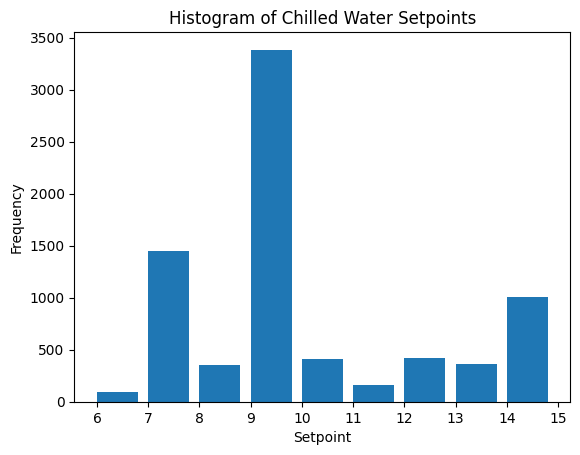

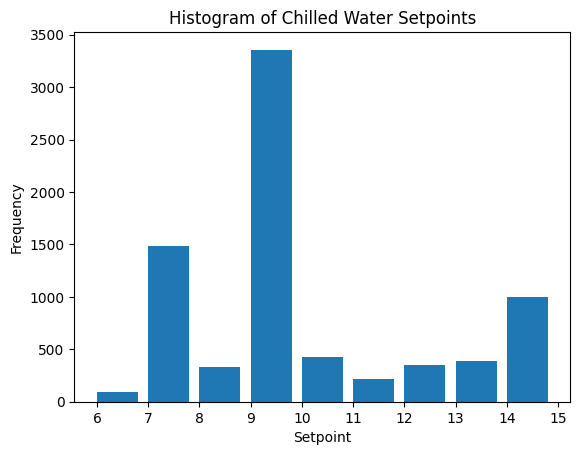

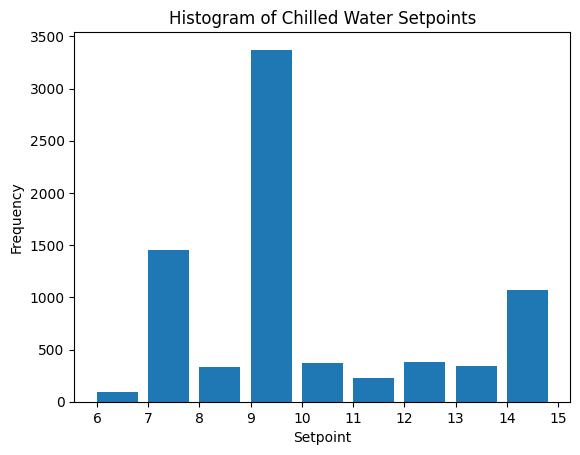

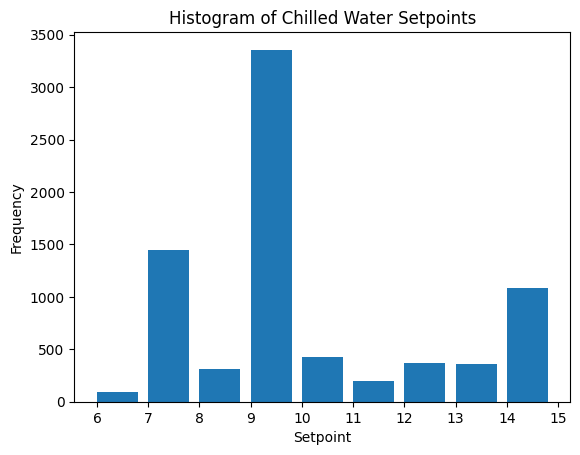

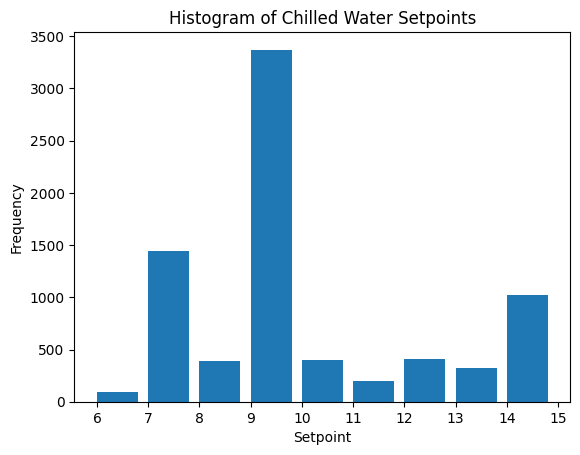

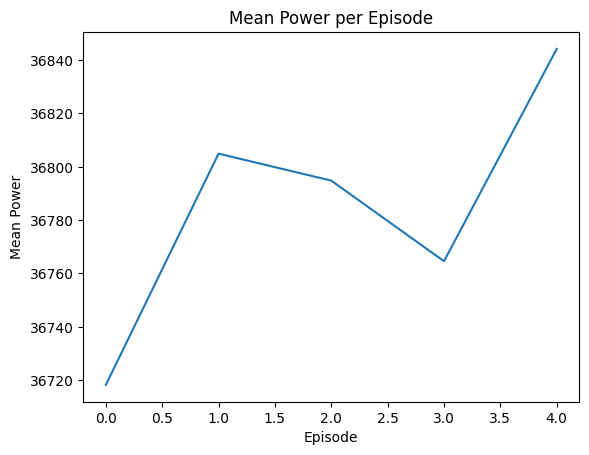

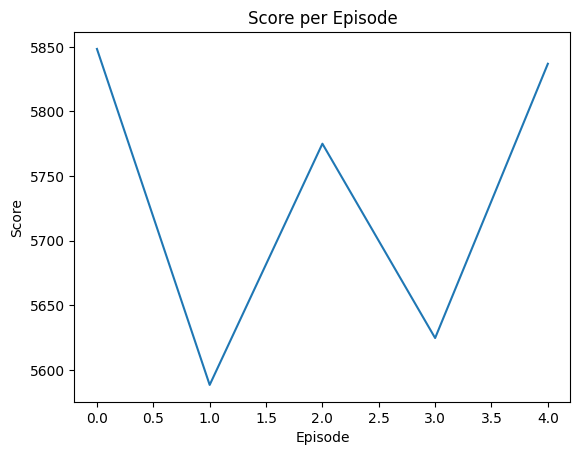

In [11]:
import numpy as np
import matplotlib.pyplot as plt

mean_power_history = []

for episode in range(5):
    mean_power_history.append(np.mean(power_history[episode]))

    '''
    plt.plot(power_history[episode])
    plt.xlabel('Step')
    plt.ylabel('Total Power')
    plt.title('Total Power per Step' + f' (Episode {episode+1})')
    plt.show()
    '''

    counts, bins = np.histogram(setpoints_history[episode], bins=np.arange(6, 16))

    plt.bar(bins[:-1], counts, width=0.8, align='edge')
    plt.xlabel('Setpoint')
    plt.ylabel('Frequency')
    plt.title('Histogram of Chilled Water Setpoints')
    plt.xticks(np.arange(6, 16))
    plt.show()
    

plt.plot(mean_power_history)
plt.xlabel('Episode')
plt.ylabel('Mean Power')
plt.title('Mean Power per Episode')
plt.show()

plt.plot(score_history)
plt.xlabel('Episode')
plt.ylabel('Score')
plt.title('Score per Episode')
plt.show()







In [17]:
import energyplus.ooep as ooep
import energyplus.ooep.ems
import energyplus.ooep.addons.state

from energyplus.dataset.basic import dataset as epds

env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./jan4.idf',
    verbose=True,
)


In [18]:

import numpy as np
score_history = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

#agent = Agent(alpha=1e-5, gamma=0.99, n_actions=4)
episode_counter = 0

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass

0.0


In [19]:
score = 0
scores = []
eps_history = []
powers = []
setpoints = []
keys = ['CHILLER', 'CHILLER 1', 'CHILLER 2']

agent = Agent(input_dims=10, n_actions=4)

for i in range(1, 7680):
    P_ch = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value
    powers.append(power)
    obs = []
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        obs.append(chiller_electricity_rate.value)
        power_sum += chiller_electricity_rate.value
    
    obs.append(T_outdoor.value)

    for chiller_evaporator_outlet_temp in T_chws:
        obs.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr:
        obs.append(chiller_evaporator_inlet_temp.value)
    
    reward = 120000/ (power_sum + 10000)

    score += reward

    action = agent.choose_action(obs)
    sm_stepf()

    P_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor_ = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws_ = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr_ = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set_ = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
            
    obs_ = []
    for chiller_electricity_rate in P_ch_:
        obs_.append(chiller_electricity_rate.value)

    obs_.append(T_outdoor_.value)

    for chiller_evaporator_outlet_temp in T_chws_:
        obs_.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr_:
        obs_.append(chiller_evaporator_inlet_temp.value)


    agent.learn(obs, action, reward, obs_)

    print(rf"Step={i}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

    setpoints.append(action + 6)

eps_history.append(agent.epsilon)

scores.append(score)

Step=1  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=9) 
Step=2  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=8) 
Step=3  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=6) 
Step=4  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.799999999999997) (T_chws_set=7) 
Step=5  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=7) 
Step=6  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=7  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=6) 
Step=8  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=8) 
Step=9  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=7) 
Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=6) 
Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=7) 
Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.474999999999998) (T_chws_set=6) 
Step=13  P_ch=(0.0, 0.0, 

Mean Power: 36306.985366584064
Median Power: 0.0
Standard Deviation of Power: 47045.65493777059
Minimum Power: 0.0
Maximum Power: 251029.1767051498


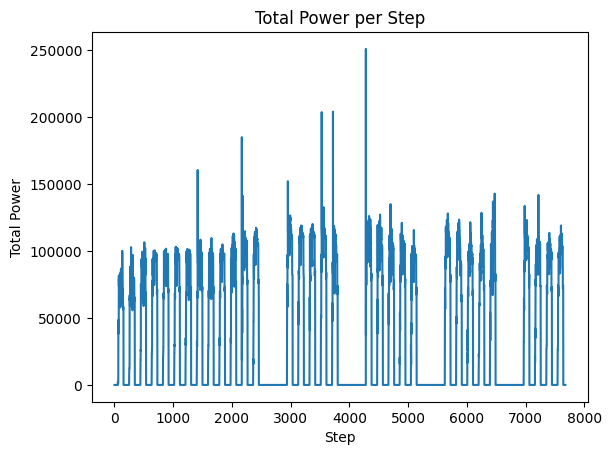

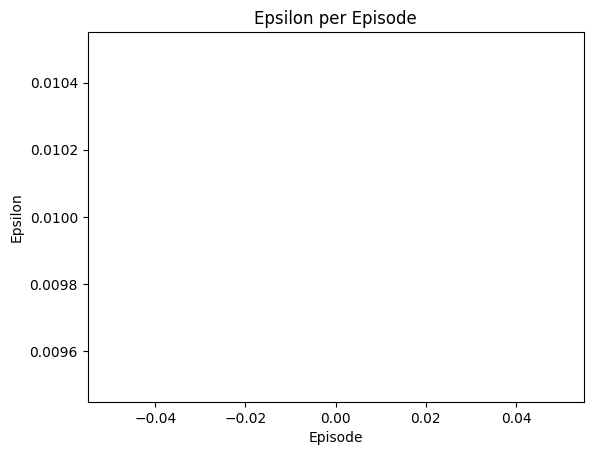

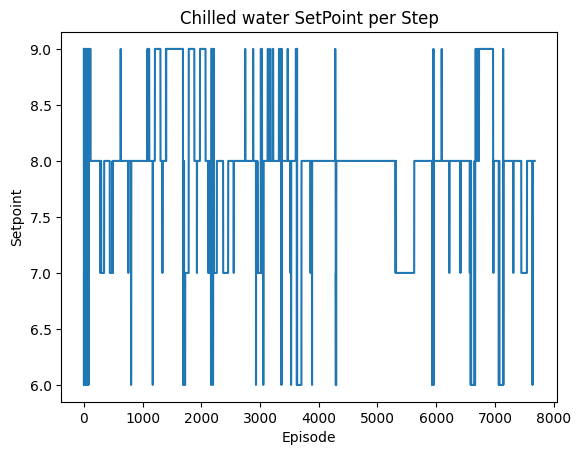

In [20]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(powers)
median_power = np.median(powers)
std_power = np.std(powers)
min_power = np.min(powers)
max_power = np.max(powers)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(powers)
plt.xlabel('Step')
plt.ylabel('Total Power')
plt.title('Total Power per Step')
plt.show()

plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode')
plt.show()

plt.plot(setpoints)
plt.xlabel('Episode')
plt.ylabel('Setpoint')
plt.title('Chilled water SetPoint per Step')
plt.show()


In [21]:
print (score)
print (agent.epsilon)

59472.744931816516
0.01


Episode 2

In [22]:
env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./jan4.idf',
    verbose=True,
)

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass


score1 = 0
powers1 = []
setpoints1 = []

for i in range(1, 7680):
    P_ch = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value
    powers1.append(power)
    obs = []
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        obs.append(chiller_electricity_rate.value)
        power_sum += chiller_electricity_rate.value
    
    obs.append(T_outdoor.value)

    for chiller_evaporator_outlet_temp in T_chws:
        obs.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr:
        obs.append(chiller_evaporator_inlet_temp.value)
    
    reward = 120000/ (power_sum + 10000)

    score1 += reward

    action = agent.choose_action(obs)
    sm_stepf()

    P_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor_ = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws_ = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr_ = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set_ = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
            
    obs_ = []
    for chiller_electricity_rate in P_ch_:
        obs_.append(chiller_electricity_rate.value)

    obs_.append(T_outdoor_.value)

    for chiller_evaporator_outlet_temp in T_chws_:
        obs_.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr_:
        obs_.append(chiller_evaporator_inlet_temp.value)


    agent.learn(obs, action, reward, obs_)

    print(rf"Step={i}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

    setpoints1.append(action + 6)

eps_history.append(agent.epsilon)

scores.append(score1)

Step=1  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=25.000000000000004) (T_chws_set=8) 
Step=2  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.9) (T_chws_set=8) 
Step=3  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.799999999999997) (T_chws_set=8) 
Step=4  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.799999999999997) (T_chws_set=8) 
Step=5  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=8) 
Step=6  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=8) 
Step=7  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.7) (T_chws_set=8) 
Step=8  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=8) 
Step=9  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.625) (T_chws_set=8) 
Step=10  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.549999999999997) (T_chws_set=8) 
Step=11  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.474999999999998) (T_chws_set=8) 
Step=12  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.474999999999998) (T_chws_set=8) 
Step=13  

0.0


Step=17  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.349999999999998) (T_chws_set=8) 
Step=18  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.299999999999997) (T_chws_set=8) 
Step=19  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.299999999999997) (T_chws_set=8) 
Step=20  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=8) 
Step=21  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.25) (T_chws_set=8) 
Step=22  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.2) (T_chws_set=8) 
Step=23  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.174999999999997) (T_chws_set=8) 
Step=24  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.174999999999997) (T_chws_set=8) 
Step=25  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.174999999999997) (T_chws_set=8) 
Step=26  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.15) (T_chws_set=8) 
Step=27  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.125000000000004) (T_chws_set=8) 
Step=28  P_ch=(0.0, 0.0, 0.0)) Reward=12.0 (T_outdoor=24.125000

Mean Power: 36244.57747521037
Median Power: 0.0
Standard Deviation of Power: 46851.96411978071
Minimum Power: 0.0
Maximum Power: 200493.1167753376


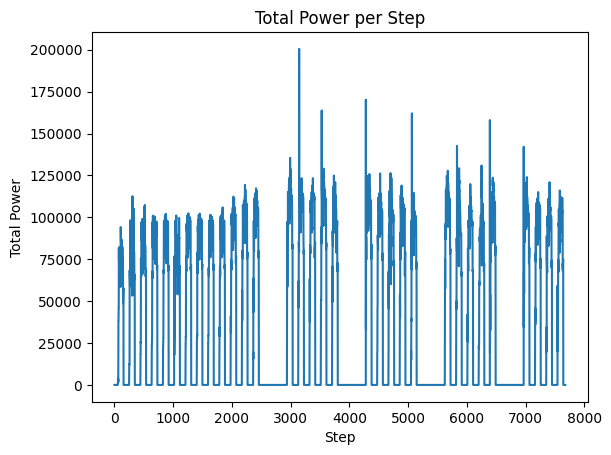

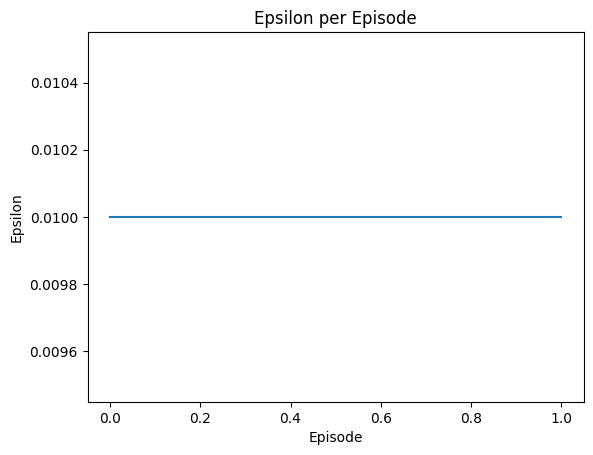

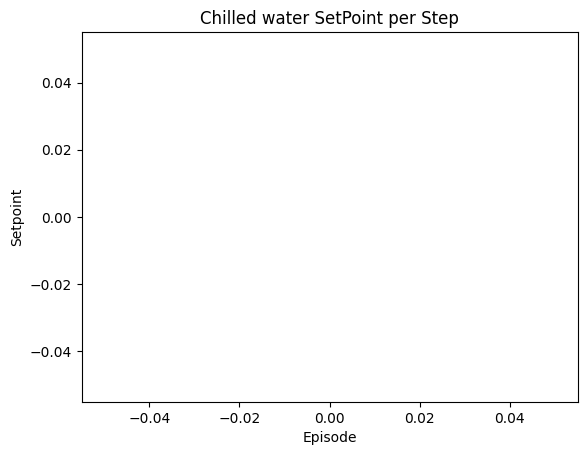

In [24]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate statistics
mean_power = np.mean(powers1)
median_power = np.median(powers1)
std_power = np.std(powers1)
min_power = np.min(powers1)
max_power = np.max(powers1)

# Print statistics
print(f"Mean Power: {mean_power}")
print(f"Median Power: {median_power}")
print(f"Standard Deviation of Power: {std_power}")
print(f"Minimum Power: {min_power}")
print(f"Maximum Power: {max_power}")

# Plot the data
plt.plot(powers1)
plt.xlabel('Step')
plt.ylabel('Total Power')
plt.title('Total Power per Step')
plt.show()

plt.plot(eps_history)
plt.xlabel('Episode')
plt.ylabel('Epsilon')
plt.title('Epsilon per Episode')
plt.show()

plt.plot(setpoints1)
plt.xlabel('Episode')
plt.ylabel('Setpoint')
plt.title('Chilled water SetPoint per Step')
plt.show()


Episode 3

In [25]:
env = energyplus.ooep.ems.Environment().__enter__()

sm_env = ooep.addons.state.StateMachine(env)
sm_stepf = sm_env.step_function(
    dict(event_name='begin_zone_timestep_after_init_heat_balance')
)

sm_env.run(
    '--output-directory', 'build3/demo-eplus',
    '--weather', f'./SGP_Singapore_486980_IWEC.epw',
    f'./jan4.idf',
    verbose=True,
)

while True:

    score = 0
    sm_stepf()


    try:

        P_ch = [env.variable(dict(
                    variable_name='Chiller Electricity Rate',
                    variable_key=key)) for key in keys]
        power = P_ch[0].value + P_ch[1].value + P_ch[2].value

        print(power)
        break

    except ooep.ems.NotReadyError: pass


score2 = 0
powers2 = []
setpoints2 = []

for i in range(1, 7680):
    P_ch = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
    power = P_ch[0].value + P_ch[1].value + P_ch[2].value
    powers2.append(power)
    obs = []
    power_sum = 0

    # Add Chiller Electricity values to the observation space
    for chiller_electricity_rate in P_ch:
        obs.append(chiller_electricity_rate.value)
        power_sum += chiller_electricity_rate.value
    
    obs.append(T_outdoor.value)

    for chiller_evaporator_outlet_temp in T_chws:
        obs.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr:
        obs.append(chiller_evaporator_inlet_temp.value)
    
    reward = 120000/ (power_sum + 10000)

    score2 += reward

    action = agent.choose_action(obs)
    sm_stepf()

    P_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity Rate',
        variable_key=key)) for key in keys]
    E_ch_ = [env.variable(dict(
        variable_name='Chiller Electricity', 
        variable_key=key)) for key in keys]
    T_outdoor_ = env.variable(dict(
        variable_name='Site Outdoor Air Drybulb Temperature',
        variable_key='ENVIRONMENT'))
    T_chws_ = [env.variable(dict(
        variable_name='Chiller Evaporator Outlet Temperature', 
        variable_key=key)) for key in keys]
    T_chwr_ = [env.variable(dict(
        variable_name='Chiller Evaporator Inlet Temperature', 
        variable_key=key)) for key in keys]
    T_chws_set_ = env.actuator(dict(
        component_type='System Node Setpoint',
        control_type = 'Temperature Setpoint', 
        actuator_key='CHW Loop Supply Side Outlet'))
            
    obs_ = []
    for chiller_electricity_rate in P_ch_:
        obs_.append(chiller_electricity_rate.value)

    obs_.append(T_outdoor_.value)

    for chiller_evaporator_outlet_temp in T_chws_:
        obs_.append(chiller_evaporator_outlet_temp.value)

    for chiller_evaporator_inlet_temp in T_chwr_:
        obs_.append(chiller_evaporator_inlet_temp.value)


    agent.learn(obs, action, reward, obs_)

    print(rf"Step={i}  P_ch={P_ch[0].value,P_ch[1].value,P_ch[2].value}) Reward={reward} (T_outdoor={T_outdoor.value}) (T_chws_set={action + 6}) ", flush=True, file=__import__('sys').stderr)

    setpoints2.append(action + 6)

eps_history.append(agent.epsilon)

scores.append(score2)

KeyboardInterrupt: 